In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import torch
torch.cuda.set_device(0)
import pandas as pd
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(suppress=True)
from Utils import *

In [3]:
import sys
sys.path.insert(0, 'preprocess/')
import vectorizer

import pickle

In [4]:
vec = pickle.load(open('preprocess/Tweets/vec_adr.p', 'rb'))
add_frequencies(vec, vec.seq_text['train'])

In [5]:
import model.Attn_Word_Pert as M
Model = M.Model

In [6]:
X, Xt = vec.seq_text['train'], vec.seq_text['test']
y, yt = vec.label['train'], vec.label['test']

In [7]:
X, y = filterbylength(X, y, min_length=5, max_length=100)
Xt, yt = filterbylength(Xt, yt, min_length=5, max_length=100)

Xt, yt = sortbylength(Xt, yt)

In [8]:
pos_weight = 1 #len(y)/sum(y) - 1

In [11]:
from sklearn.metrics import classification_report, f1_score

def train(name='') :
    model = Model(vec.vocab_size, vec.word_dim, 64, dirname='tweet', hidden_size=128, pre_embed=vec.embeddings)
    best_f1 = 0.0
    for i in tqdm_notebook(range(10)) :
        loss = model.train(X, y)
        o, he = model.evaluate(Xt)
        o = np.array(o)
        rep = classification_report(yt, (o > 0.5))
        f1 = f1_score(yt, (o > 0.5), pos_label=1)
        print(rep)
        stmt = '%s, %s' % (i, loss)
        if f1 > best_f1 and i > 2:
            best_f1 = f1
            dirname = model.save_values(add_name=name, save_model=True)
            print("Model Saved", f1)
        else :
            dirname = model.save_values(add_name=name, save_model=False)
            print("Model not saved", f1)
        f = open(dirname + '/epoch.txt', 'a')
        f.write(stmt + '\n')
        f.write(rep + '\n')
        f.close()
    
    return model

In [12]:
train(name='first_final_tweet_adr')

Setting Embedding


              precision    recall  f1-score   support

           0       0.92      0.99      0.95      3636
           1       0.77      0.36      0.49       487

   micro avg       0.91      0.91      0.91      4123
   macro avg       0.84      0.67      0.72      4123
weighted avg       0.90      0.91      0.90      4123

Model not saved 0.4916201117318436


              precision    recall  f1-score   support

           0       0.94      0.97      0.95      3636
           1       0.69      0.55      0.61       487

   micro avg       0.92      0.92      0.92      4123
   macro avg       0.81      0.76      0.78      4123
weighted avg       0.91      0.92      0.91      4123

Model not saved 0.6104783599088838


              precision    recall  f1-score   support

           0       0.94      0.96      0.95      3636
           1       0.66      0.58      0.62       487

   micro avg       0.91      0.91      0.91      4123
   macro avg       0.80      0.77      0.78      4123
weighted avg       0.91      0.91      0.91      4123

Model not saved 0.6150490730643403


              precision    recall  f1-score   support

           0       0.94      0.96      0.95      3636
           1       0.64      0.58      0.61       487

   micro avg       0.91      0.91      0.91      4123
   macro avg       0.79      0.77      0.78      4123
weighted avg       0.91      0.91      0.91      4123

Model Saved 0.6090712742980562


              precision    recall  f1-score   support

           0       0.94      0.96      0.95      3636
           1       0.64      0.53      0.58       487

   micro avg       0.91      0.91      0.91      4123
   macro avg       0.79      0.74      0.76      4123
weighted avg       0.90      0.91      0.91      4123

Model not saved 0.5794813979706877


              precision    recall  f1-score   support

           0       0.94      0.95      0.95      3636
           1       0.62      0.56      0.59       487

   micro avg       0.91      0.91      0.91      4123
   macro avg       0.78      0.76      0.77      4123
weighted avg       0.90      0.91      0.91      4123

Model not saved 0.5920344456404737


              precision    recall  f1-score   support

           0       0.95      0.90      0.93      3636
           1       0.47      0.68      0.56       487

   micro avg       0.87      0.87      0.87      4123
   macro avg       0.71      0.79      0.74      4123
weighted avg       0.90      0.87      0.88      4123

Model not saved 0.5557432432432432


              precision    recall  f1-score   support

           0       0.95      0.94      0.94      3636
           1       0.56      0.60      0.58       487

   micro avg       0.90      0.90      0.90      4123
   macro avg       0.75      0.77      0.76      4123
weighted avg       0.90      0.90      0.90      4123

Model not saved 0.5796812749003984


              precision    recall  f1-score   support

           0       0.94      0.95      0.95      3636
           1       0.60      0.56      0.58       487

   micro avg       0.90      0.90      0.90      4123
   macro avg       0.77      0.75      0.76      4123
weighted avg       0.90      0.90      0.90      4123

Model not saved 0.5793397231096912


              precision    recall  f1-score   support

           0       0.94      0.96      0.95      3636
           1       0.62      0.53      0.57       487

   micro avg       0.91      0.91      0.91      4123
   macro avg       0.78      0.74      0.76      4123
weighted avg       0.90      0.91      0.90      4123

Model not saved 0.5723756906077349


# **EVALUATION**

In [13]:
def load_model(dirname) :
    model = Model(vec.vocab_size, vec.word_dim, 64, dirname='tweet', hidden_size=128, pre_embed=vec.embeddings)
    model.dirname = dirname
    model.load_values(dirname)
    return model

In [14]:
model = load_model('outputs/attn_word_tweet/FriOct1918:56:102018_first_final_tweet_adr/')

Setting Embedding


In [15]:
yt_hat, attn_hat = evaluate_and_print(model, Xt, yt)

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      3636
           1       0.64      0.58      0.61       487

   micro avg       0.91      0.91      0.91      4123
   macro avg       0.79      0.77      0.78      4123
weighted avg       0.91      0.91      0.91      4123



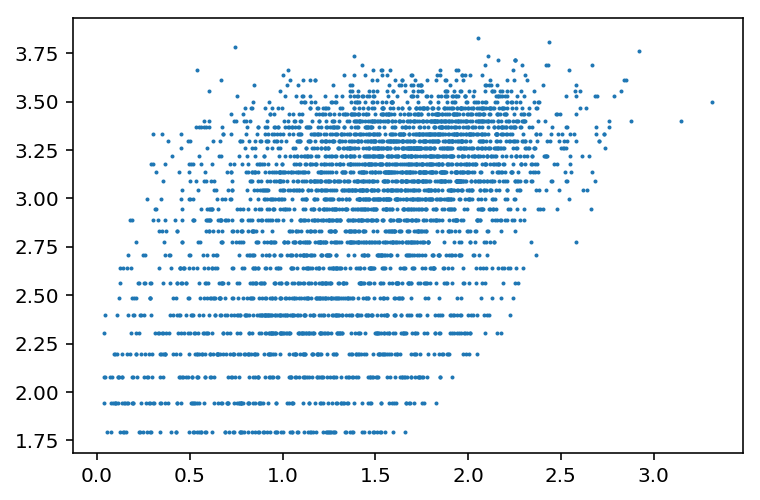

In [16]:
plot_entropy(Xt, attn_hat)

# __Sampling__

In [ ]:
model.vec = vec
sampled_output = model.sampling_top(Xt, sample_vocab=100, topnum=5)

In [ ]:
import pickle
pickle.dump(sampled_output, open(model.dirname + '/sampled.p', 'wb'))

In [ ]:
sampled_output = pickle.load(open(model.dirname + '/sampled.p', 'rb'))

In [ ]:
generate_medians_from_sampling_top(sampled_output, attn_hat, yt_hat, dirname=model.dirname)

In [ ]:
distractors = get_distractors(sampled_output, attn_hat)
print_few_distractors(vec, Xt, attn_hat, sampled_output, distractors)

In [ ]:
print_attn(vec.map2words(Xt[1000]), attn_hat[1000])

**Gradients**
=============

In [17]:
grads = model.gradient_mem(Xt)
process_grads(grads)

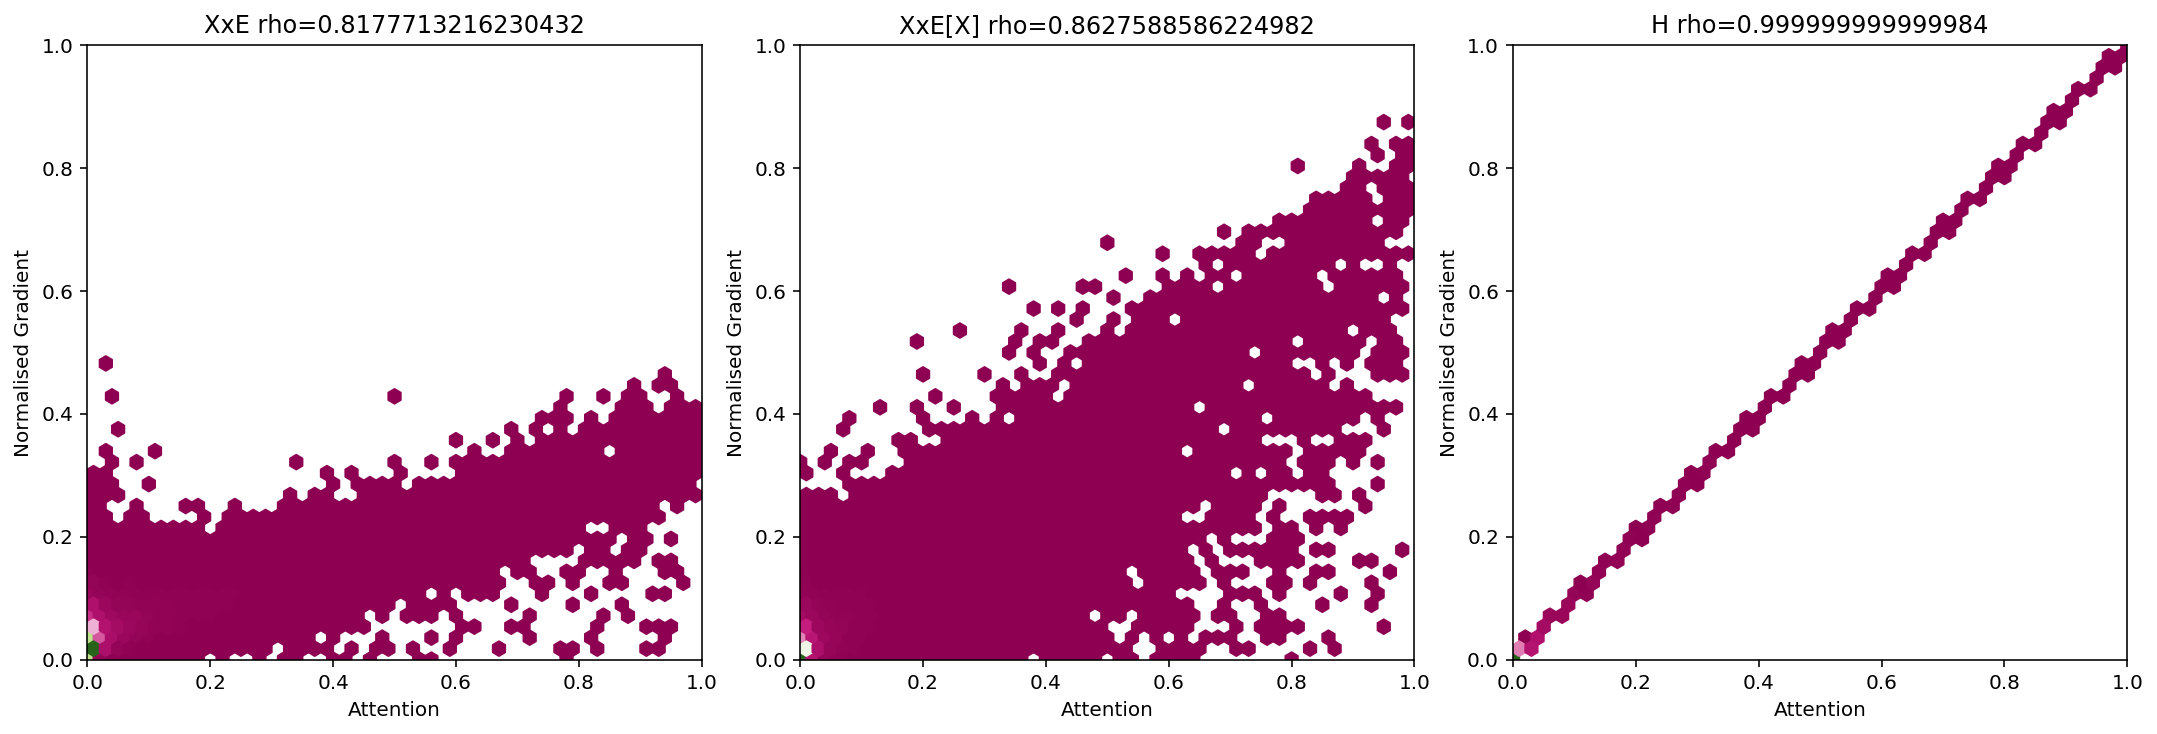

In [18]:
plot_grads(Xt, attn_hat, grads, dirname=model.dirname)

**Permutation**
===========

In [19]:
perms = model.permute_attn(Xt)

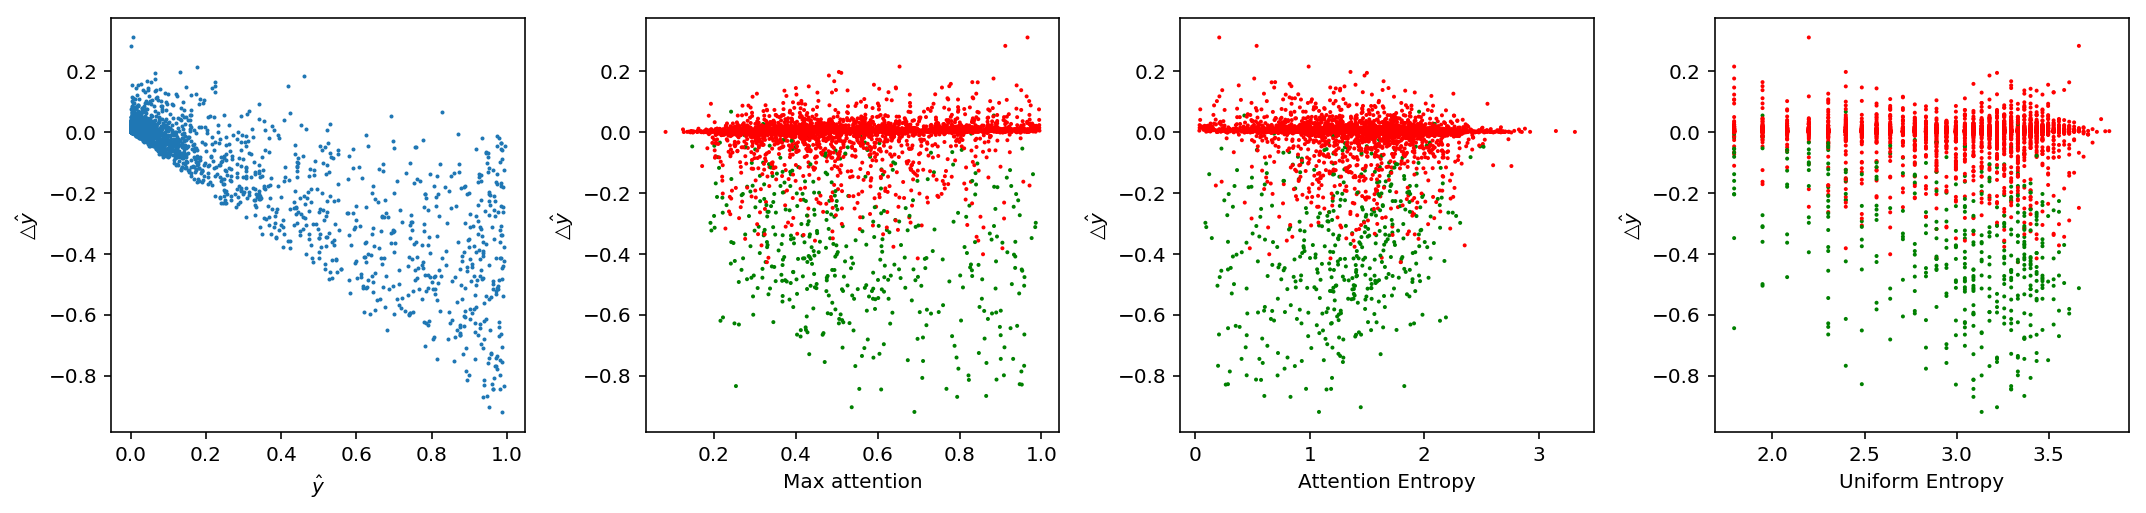

In [20]:
plot_permutations(perms, Xt, yt_hat, attn_hat, dirname=model.dirname)

**Adversarial Attention**
=========================

In [21]:
adversarial_outputs = model.adversarial(Xt, _type='uniform')
ad_y, ad_attn = adversarial_outputs

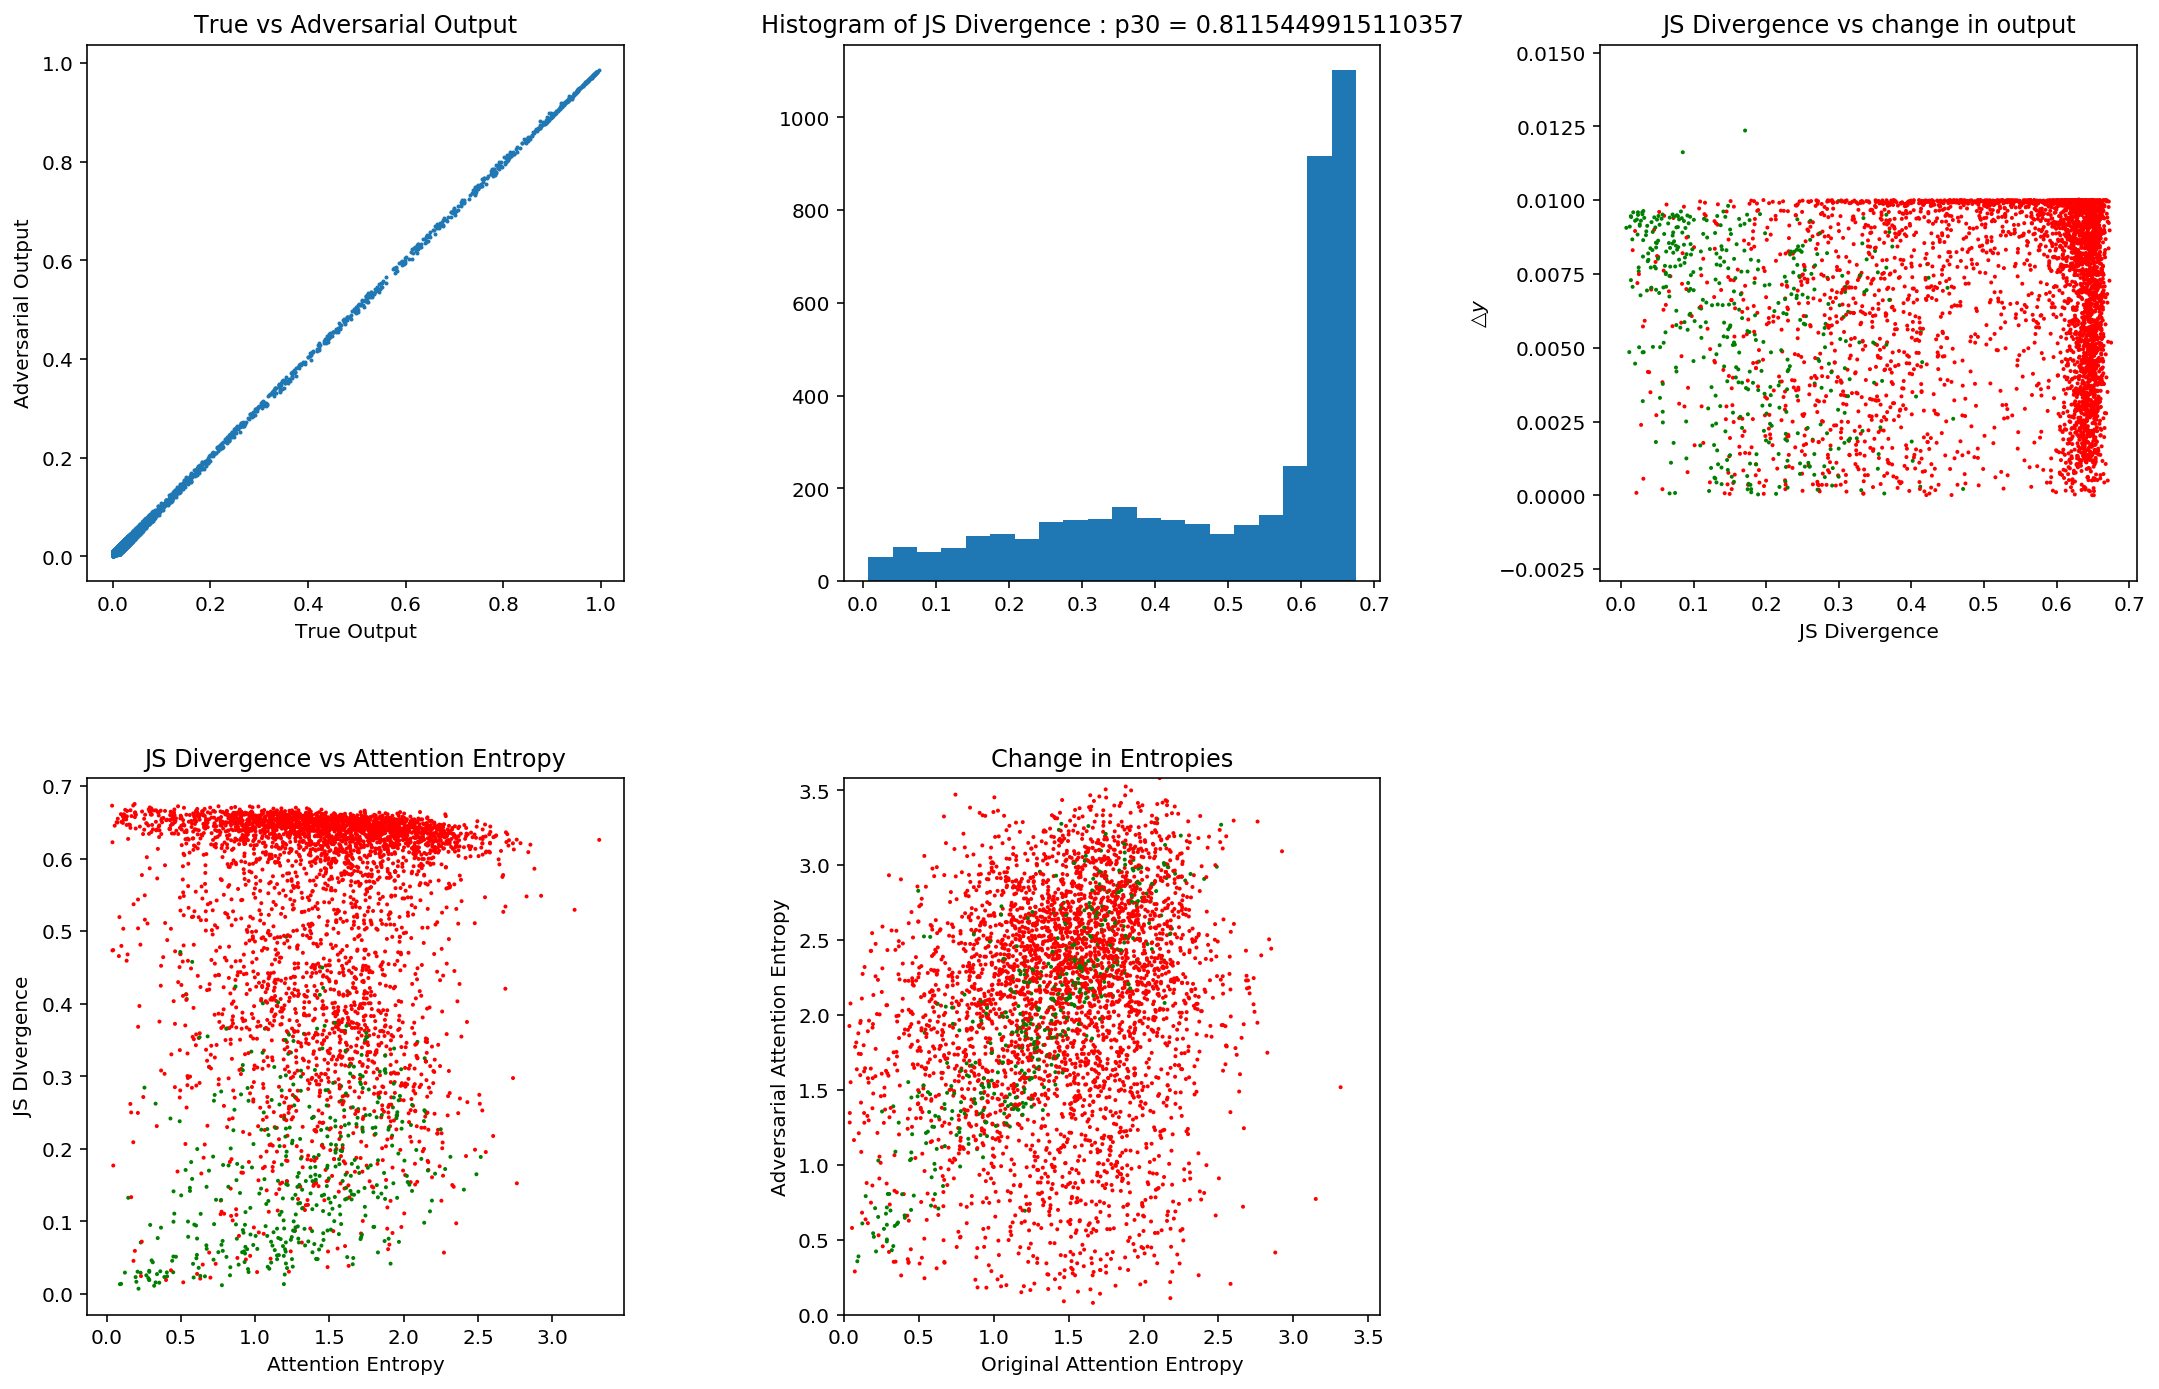

In [22]:
jds = plot_adversarial(Xt, yt_hat, attn_hat, adversarial_outputs, dirname=model.dirname)

In [23]:
idx = list(np.where(np.logical_and(np.array(jds) > 0.5, yt_hat > 0.7))[0])[:30]
idx

[]

In [24]:
n = 113
print_adversarial_example(vec.map2words(X[n]), attn_hat[n], ad_attn[n])
print(yt_hat[n], ad_y[n])

--------------------


0.00026588986 [0.00556455]


**Zero Runs** -- p(y|x, c) - p(y|x)
=============

In [25]:
zero_runs = model.zero_H_run(Xt)

In [26]:
zero_outputs, zero_H_diff = zero_runs

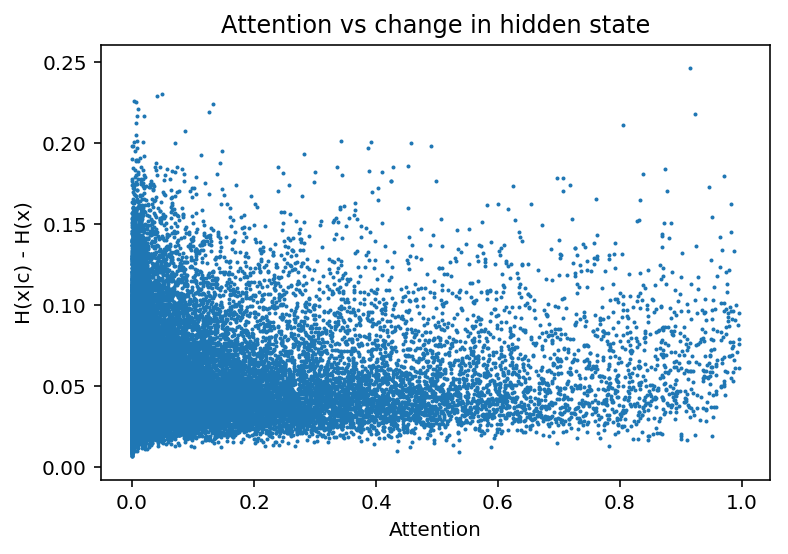

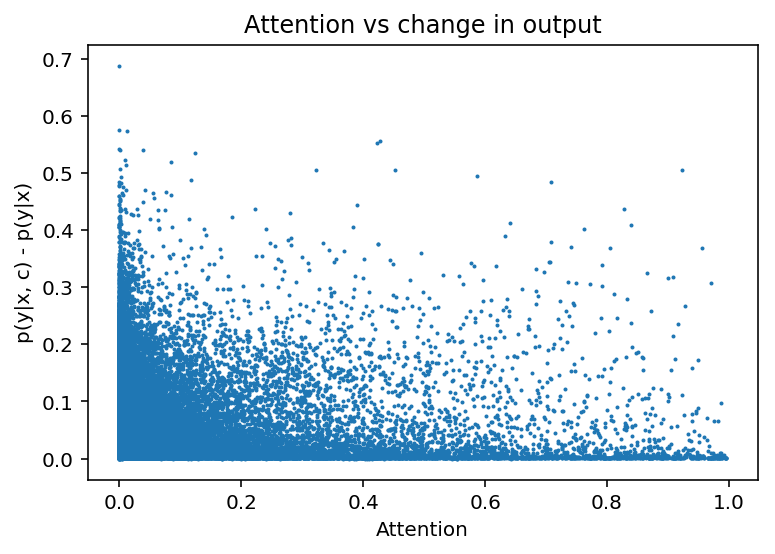

In [27]:
plot_attn_diff(Xt, attn_hat, zero_H_diff, xlabel='Attention', ylabel="H(x|c) - H(x)", 
               title="Attention vs change in hidden state", save_name="hxc-hx.pdf", dirname=model.dirname)
plot_y_diff(X, attn_hat, yt_hat, zero_outputs, xlabel="Attention", ylabel="p(y|x, c) - p(y|x)", 
            title="Attention vs change in output", save_name="pyxc-pyx.pdf", dirname=model.dirname)

**Remove and Run** -- p(y|x, c) - p(y|c)
==================

In [28]:
remove_outputs = model.remove_and_run(Xt)

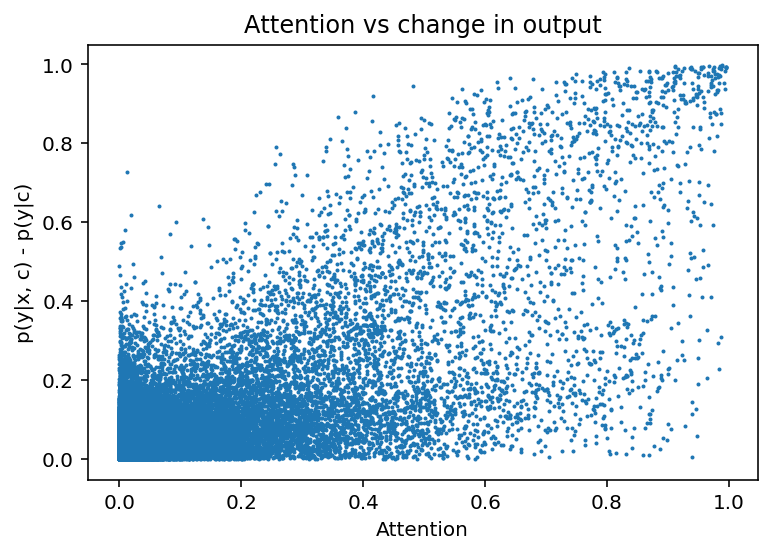

In [29]:
plot_y_diff(Xt, attn_hat, yt_hat, remove_outputs, xlabel="Attention", ylabel="p(y|x, c) - p(y|c)", 
            title="Attention vs change in output", save_name="pyxc-pyc.pdf", dirname=model.dirname)

**Perturbation**
================

In [30]:
perturb_outputs = model.perturbation_embedding(Xt)

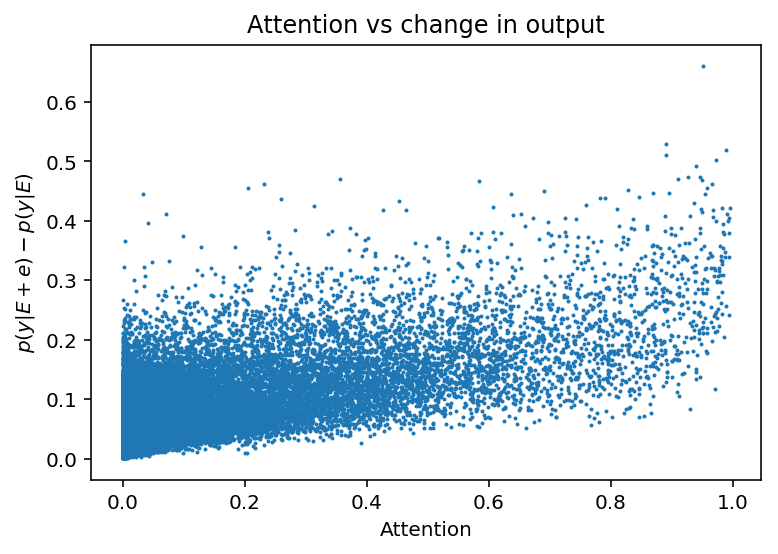

In [31]:
plot_pertub_embedding(Xt, attn_hat, yt_hat, perturb_outputs, dirname=model.dirname)